**to do** should consider adding PCA highest variance features to the oveall features in a second part

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [27]:
def load_data(filename, selected_features="all"):
#     should probably do two in one ... load only those columns we need? idk
    data = pd.read_csv(filename, encoding="unicode_escape")
    if selected_features is not "all":
        return data[selected_features]
    else:
        return data
    
    
def get_column_type(data, n_cont_threshold=6):
    types = pd.DataFrame([[data.columns[idx], data[val].nunique()] for idx, val in enumerate(data)],
                        columns = ["features", "unique_values"])
    numerical = list(types[types["unique_values"]>n_cont_threshold]["features"])
    categorical = list(types[(types["unique_values"]<n_cont_threshold)&(types["unique_values"]>2)]["features"])
    binary = list(types[types["unique_values"]==2]["features"])
    return numerical, categorical, binary


def get_data_description(data, info):
    description = pd.DataFrame([[data.columns[idx],
                           data[val].nunique(),
                           data[val].isnull().sum(),
                           data[val].isnull().sum()/len(data[val]),
                           data[val].min(),
                           data[val].max(),
                           list(data[val].value_counts(normalize=False).values)] for idx, val in enumerate(data.columns)],
                         columns = ["name", "nunique", "nnull","%null","min","max","counts"])
    
    description = pd.merge(description, info.drop(["format"], axis=1), on = "name" , how="left")
#     not sure its great to pass extra arguments inside the apply 100 times...
    description["type"] = description["name"].apply(lambda x: get_column_type_from_list(x, numerical, categorical, binary))
    description["ratio"] = description[description["type"]=="bin"].apply(lambda x: x["counts"][0]/x["counts"][1] if x["counts"][1]>0 else None,
                                                                                                                    axis= 1)
    return description

In [48]:
main_filename = "../data/epoct_ezvir_05dec2018_unlabeled_Jan.csv"
labels_filename = "../data/alge_data/epoct_ezvir_05dec2018_dictionary.csv"
selected_features = ["date_season_meteo",
           "dem_age_int",
           "dem_sex",
            "lab_malaria_any_d0",
            "signv_temp_d0",
            "symp_abdopain",
            "symp_cough",
            "symp_fev24h",
            "symp_vomit",
            "signv_rr1_d0",
            "days_of_fever",]

data = load_data(main_filename, selected_features)
full_data = load_data(main_filename)
info = load_data(labels_filename, ["name","format","varlab"])

In [49]:
numerical, categorical, binary = get_column_type(data)

get_data_description(data, info)

,name,nunique,nnull,%null,min,max,counts,varlab,type,ratio
0,date_season_meteo,3,0,0.000000,1.0,3.0,"[1715, 858, 619]",Season according to meteorological data,cat,NaN
1,dem_age_int,58,0,0.000000,2.0,59.0,"[188, 178, 177, 172, 169, 155, 148, 136, 134, ...",NaN,num,NaN
2,dem_sex,2,0,0.000000,1.0,2.0,"[1766, 1426]",Sex,bin,1.238429
3,lab_malaria_any_d0,2,192,0.060150,0.0,1.0,"[2680, 320]",LAB: Any malaria positive test (mRDT or hsmRDT...,bin,8.375000
4,signv_temp_d0,68,6,0.001880,37.5,42.0,"[242, 225, 145, 141, 128, 128, 114, 109, 107, ...","Axillary temperature, D0",num,NaN
5,symp_abdopain,2,1,0.000313,0.0,1.0,"[3043, 148]",Symptom: abdominal pain,bin,20.560811
6,symp_cough,2,0,0.000000,0.0,1.0,"[1847, 1345]",Symptom: Cough (d0-d3),bin,1.373234
7,symp_fev24h,2,0,0.000000,0.0,1.0,"[1986, 1206]","Symptom: 0=>24h fever before presentation, 1 =...",bin,1.646766
8,symp_vomit,2,0,0.000000,0.0,1.0,"[2557, 635]",Symptom: Vomiting (d0-d3),bin,4.026772
9,signv_rr1_d0,62,12,0.003759,20.0,90.0,"[182, 176, 155, 144, 140, 125, 108, 105, 102, ...","Initial RR entered, D0",num,NaN


In [50]:
def remove_null_label(data, label):
    return data[~data[label].isnull()]

In [51]:
data.shape

(3192, 11)

In [52]:
y_label=["lab_malaria_any_d0"]

data = remove_null_label(data, y_label[0])

In [53]:
data.shape

(3000, 11)

- nans: remove if too many
- remove tests results (would be too easy to predict...)
- go through features that would make no sense (geographical or else) for what we set out to do
- min max scaling for numerical
- binary  / categorical : make sure is label encoded / OHE
- oversampling
- train test and validation: prob 60 30 10 
- should also run boruta or L1 for feature selection
    


In [56]:
import sklearn
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, Binarizer, LabelEncoder, MinMaxScaler

from pprint import pprint
from time import time

## preprocessing pipeline

In [67]:
data.dropna(inplace=True)
X_labels=list(set(selected_features)-set(y_label))
X=np.array(data[X_labels])
y = np.array(data[y_label]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [80]:
def get_feature_type_indices(feature_type, data):
    return [1 if i in feature_type else 0 for i in data.columns]


def create_preprocessing_pipeline(data, numerical, categorical, binary):

    numerical_idx= get_feature_type_indices(numerical, data)
    categorical_idx=get_feature_type_indices(categorical, data)
    binary_idx=get_feature_type_indices(binary, data)

    numerical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
    ])
    categorical_transformer = Pipeline(steps=[
        ('onehotencoder', OneHotEncoder(categories="auto")),#handle_unknown="ignore"
    ])
    binary_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
        ('onehotencoder', OneHotEncoder(categories="auto"))
    ])

    preprocessor = ColumnTransformer(
        transformers = [
            ("num", numerical_transformer, numerical_idx),
            ("cat", categorical_transformer, categorical_idx),
            ("bin", binary_transformer, binary_idx)
        ]
    )
    return preprocessor

In [81]:
preprocessor = create_preprocessing_pipeline(data, numerical, categorical, binary)

In [82]:
set_config()
preprocessor


ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1)))]), [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1]), ('cat', Pipeline(memory=None,
    ..., handle_unknown='error',
       n_values=None, sparse=True))]), [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0])])

In [88]:
def run_grid_search_cv(pipeline, parameters, X_train, y_train, cv=5, return_train_score= True, njobs=1, verbose=1):
    grid_search = GridSearchCV(pipeline, parameters, cv=cv)
    print("gridsearch; pipeline: ", [name for name,_ in pipeline.steps])
    pprint(parameters)
    t0=time()
    grid_search.fit(X_train, y_train)
    print("time: {:.3f}".format(time()-t0))
    print("time: {:.3f}".format(grid_search.best_score_))
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(param_name, best_parameters[param_name])
    return grid_search

## Bernoulli Naive Bayes

In [114]:

np.linspace(1,100,19)

array([  1. ,   6.5,  12. ,  17.5,  23. ,  28.5,  34. ,  39.5,  45. ,
        50.5,  56. ,  61.5,  67. ,  72.5,  78. ,  83.5,  89. ,  94.5,
       100. ])

In [117]:
pipeline_BNB = Pipeline([
    ("preprocessor", preprocessor),
    ('clf', BernoulliNB()),
])

parameters_BNB= {
    'clf__alpha':(np.sort(np.append(np.logspace(-10, 10, 21), 
                                    np.linspace(10,1000,19),
                                   ))),
    'clf__fit_prior':(False, True),
}
    


In [118]:
grid_search_BNB = run_grid_search_cv(pipeline_BNB, parameters_BNB, X_train, y_train)

gridsearch; pipeline:  ['preprocessor', 'clf']
{'clf__alpha': array([1.00e-10, 1.00e-09, 1.00e-08, 1.00e-07, 1.00e-06, 1.00e-05,
       1.00e-04, 1.00e-03, 1.00e-02, 1.00e-01, 1.00e+00, 1.00e+01,
       1.00e+01, 6.50e+01, 1.00e+02, 1.20e+02, 1.75e+02, 2.30e+02,
       2.85e+02, 3.40e+02, 3.95e+02, 4.50e+02, 5.05e+02, 5.60e+02,
       6.15e+02, 6.70e+02, 7.25e+02, 7.80e+02, 8.35e+02, 8.90e+02,
       9.45e+02, 1.00e+03, 1.00e+03, 1.00e+04, 1.00e+05, 1.00e+06,
       1.00e+07, 1.00e+08, 1.00e+09, 1.00e+10]),
 'clf__fit_prior': (False, True)}
time: 10.895
time: 0.897
clf__alpha 100000.0
clf__fit_prior True


C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\util

Text(0, 0.5, 'Mean Score')

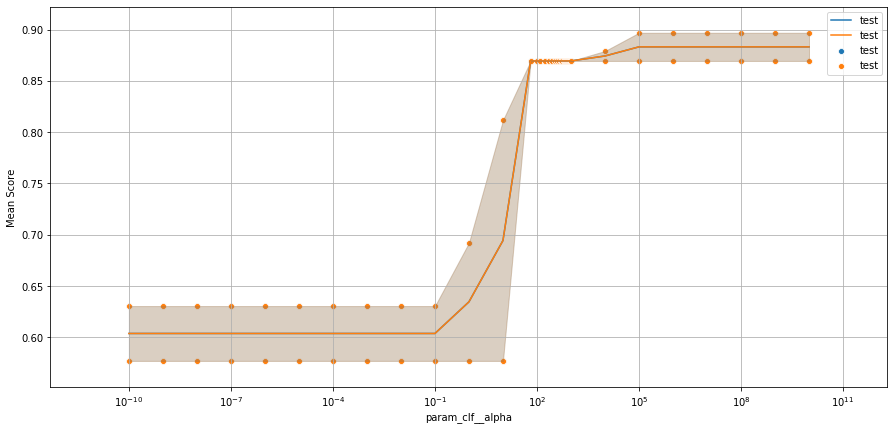

In [119]:
fig, ax = plt.subplots(figsize=(15,7))
results_BNB = pd.DataFrame(grid_search_BNB.cv_results_)
coi = "param_clf__alpha"
plt.grid(True)
ax.set_xscale("log")
sns.scatterplot(data=results_BNB, x=coi, y = "mean_test_score", label="test", ax=ax)
sns.scatterplot(data=results_BNB, x=coi, y = "mean_test_score", label="test", ax=ax)
sns.lineplot(data=results_BNB, x=coi, y = "mean_test_score", label="test", ax=ax)
sns.lineplot(data=results_BNB, x=coi, y = "mean_test_score", label="test", ax=ax)
ax.set_ylabel("Mean Score")

#              yerr = plot_results["std_test_score"])

## Logistic Regression

In [134]:
pipeline_LR = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=200, random_state=0, solver = "saga"))
])
# should try saga solver to test out l1 ,and elastic net penalties 
# liblinear also works for l1, not sure for elasticnet

# should also lower the tolerance maybe 1e-6


parameters_LR= {
    "classifier__C":np.sort((np.append(np.logspace(-4,1,6), np.linspace(1, 5, 5)))),
    "classifier__fit_intercept":(True, False),
    "classifier__penalty":("l1","l2"),
}
   
# clf.fit(X_train, y_train)
# print("model score: %.3f" % clf.score(X_test, y_test))

In [135]:
grid_search_LR = run_grid_search_cv(pipeline_LR, parameters_LR, X_train, y_train, njobs=-1)

gridsearch; pipeline:  ['preprocessor', 'classifier']
{'classifier__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+00, 2.e+00, 3.e+00,
       4.e+00, 5.e+00, 1.e+01]),
 'classifier__fit_intercept': (True, False),
 'classifier__penalty': ('l1', 'l2')}


C:\Users\theop\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

C:\Users\theop\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


time: 26.235
time: 0.897
classifier__C 0.0001
classifier__fit_intercept True
classifier__penalty l1


C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\util

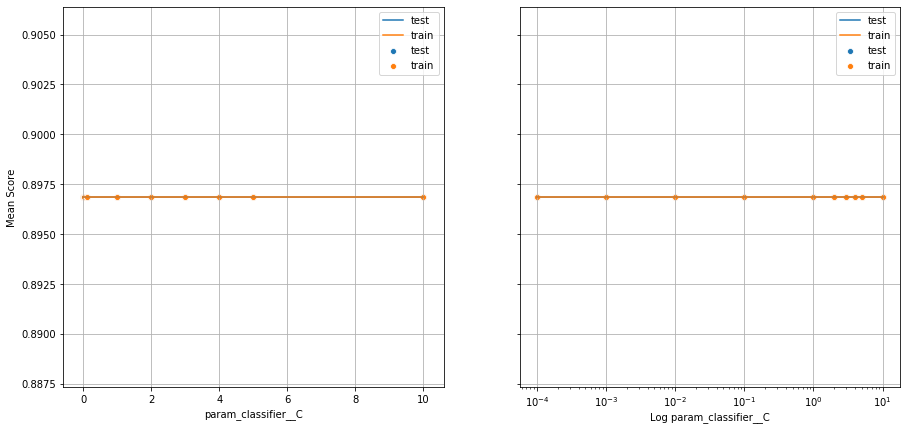

In [150]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,7))
results_LR = pd.DataFrame(grid_search_LR.cv_results_)
coi = "param_classifier__C"
sns.scatterplot(data=results_LR, x=coi, y = "mean_test_score", label="test", ax = ax[0])
sns.lineplot(data=results_LR, x=coi, y = "mean_test_score", label="test", ax = ax[0])
sns.scatterplot(data=results_LR, x=coi, y = "mean_train_score", label = "train",  ax = ax[0])
sns.lineplot(data=results_LR, x=coi, y = "mean_train_score", label = "train",  ax = ax[0])
ax[0].set_ylabel("Mean Score")
ax[0].xaxis.grid(True)
ax[0].yaxis.grid(True)

sns.scatterplot(data=results_LR, x=coi, y = "mean_test_score", label="test", ax = ax[1])
sns.lineplot(data=results_LR, x=coi, y = "mean_test_score", label="test", ax = ax[1])
sns.scatterplot(data=results_LR, x=coi, y = "mean_train_score", label = "train",  ax = ax[1])
sns.lineplot(data=results_LR, x=coi, y = "mean_train_score", label = "train",  ax = ax[1])
ax[1].set_ylabel("Mean Score")
ax[1].set_xlabel("Log {}".format(coi))
ax[1].set_xscale("log")
ax[1].xaxis.grid(True)
ax[1].yaxis.grid(True)

#              yerr = plot_results["std_test_score"])

## Random Forest

In [143]:
from sklearn.ensemble import RandomForestClassifier

class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [145]:
pipeline_RF = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=0, bootstrap = True))
])




parameters_RF= {
    "classifier__n_estimators":(10, 100, 300, 500),
#     "classifier__criterion":("gini","entropy"),
    "classifier__max_depth":(1, 2, 5, 10, None),
    "classifier__max_features":("auto","sqrt","log2",None),
#     "classifier__oob_score":(False, True)
}
   
# clf.fit(X_train, y_train)
# print("model score: %.3f" % clf.score(X_test, y_test))

In [149]:
grid_search_RF = run_grid_search_cv(pipeline_RF, parameters_RF, X_train, y_train)

gridsearch; pipeline:  ['preprocessor', 'classifier']
{'classifier__criterion': ('gini', 'entropy'),
 'classifier__max_depth': (1, 2, 5, 10, None),
 'classifier__max_features': ('auto', 'sqrt', 'log2', None),
 'classifier__n_estimators': (10, 100, 300, 500)}
time: 318.000
time: 0.897
classifier__criterion gini
classifier__max_depth 1
classifier__max_features auto
classifier__n_estimators 10


C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\util

Text(0, 0.5, 'Mean Score')

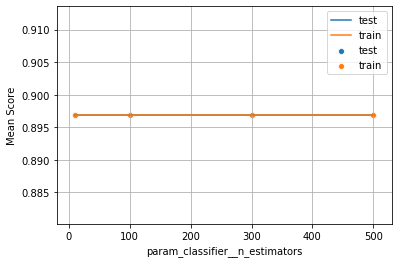

In [151]:
fig, ax = plt.subplots()
results_RF = pd.DataFrame(grid_search_RF.cv_results_)
coi = "param_classifier__n_estimators"
plt.grid(True)
sns.scatterplot(data=results_RF, x=coi, y = "mean_test_score", label="test", ax = ax)
sns.lineplot(data=results_RF, x=coi, y = "mean_test_score", label="test", ax = ax)
sns.scatterplot(data=results_RF, x=coi, y = "mean_train_score", label = "train",  ax = ax)
sns.lineplot(data=results_RF, x=coi, y = "mean_train_score", label = "train",  ax = ax)
ax.set_ylabel("Mean Score")
#              yerr = plot_results["std_test_score"])

C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\util

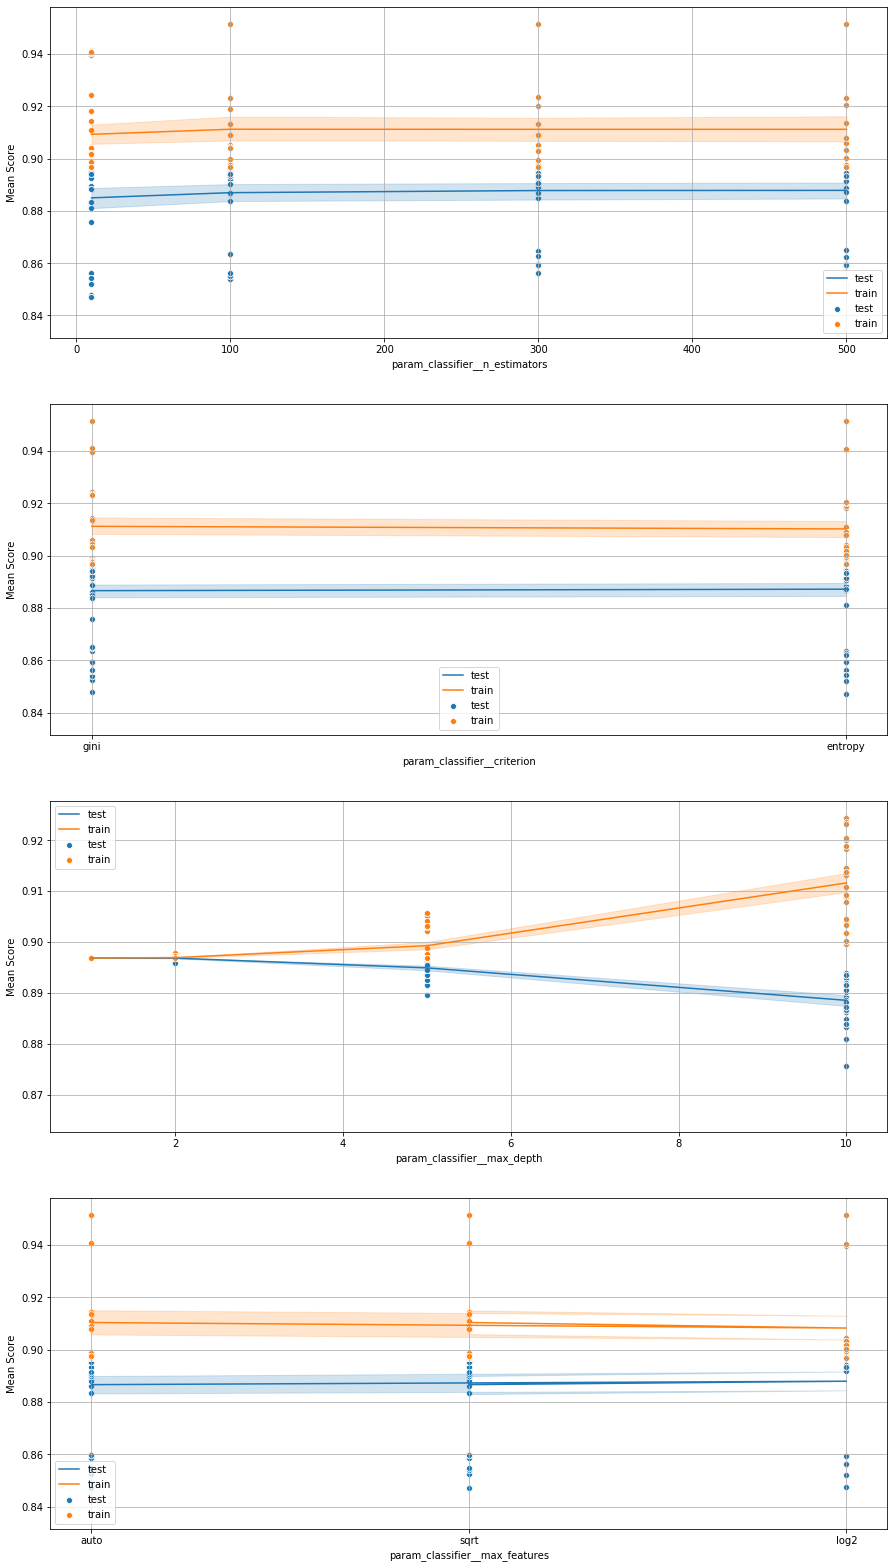

In [152]:
cois = ["param_classifier__n_estimators", "param_classifier__criterion",
       "param_classifier__max_depth", "param_classifier__max_features"]
fig, ax = plt.subplots(nrows=len(cois), figsize=(15,7*len(cois)))
results_RF = pd.DataFrame(grid_search_RF.cv_results_)
for idx, coi in enumerate(cois):
    ax[idx].xaxis.grid(True)
    ax[idx].yaxis.grid(True)
    sns.scatterplot(data=results_RF, x=coi, y = "mean_test_score", label="test", ax = ax[idx])
    sns.lineplot(data=results_RF, x=coi, y = "mean_test_score", label="test", ax = ax[idx])
    sns.scatterplot(data=results_RF, x=coi, y = "mean_train_score", label = "train",  ax = ax[idx])
    sns.lineplot(data=results_RF, x=coi, y = "mean_train_score", label = "train",  ax = ax[idx])
    ax[idx].set_ylabel("Mean Score")
#              yerr = plot_results["std_test_score"])

## Artificial Neural Network

In [183]:
from sklearn.neural_network import MLPClassifier

In [ ]:
>>> clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
...                     hidden_layer_sizes=(15,), random_state=1)


In [184]:
pipeline_NN = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("classifier", MLPClassifier(random_state=0)),
])




parameters_NN= {
    "classifier__alpha":(1e-6,1e-5,1e-4,1e-3),
    "classifier__solver":("adam", "sgd", "lbfgs"),
    "classifier__activation":("relu","tanh","logistic"),
    "classifier__hidden_layer_sizes":((50,2),(100,2),(200,2),(50,3),(100,3),(200,3)),
    
}

# could look at adaptive momentum, nesterov momentum etc but only applicable to SGD solver so run a 2nd time?
   
# clf.fit(X_train, y_train)
# print("model score: %.3f" % clf.score(X_test, y_test))

In [185]:
grid_search_NN = GridSearchCV(pipeline_NN, parameters_NN, n_jobs=1, verbose = 1)

print("gridsearch; pipeline: ", [name for name,_ in pipeline_NN.steps])
pprint(parameters_NN)
t0=time()
grid_search_NN.fit(X_train, y_train)
print("time: {:.3f}".format(time()-t0))
print("time: {:.3f}".format(grid_search_NN.best_score_))
best_parameters_NN = grid_search_NN.best_estimator_.get_params()
for param_name in sorted(parameters_NN.keys()):
    print(param_name, best_parameters_NN[param_name])   
grid_search_NN.best_score_
# pd.DataFrame(grid_search.cv_results_)

gridsearch; pipeline:  ['preprocessor', 'classifier']
{'classifier__activation': ('relu', 'tanh', 'logistic'),
 'classifier__alpha': (1e-06, 1e-05, 0.0001, 0.001),
 'classifier__hidden_layer_sizes': ((50, 2),
                                    (100, 2),
                                    (200, 2),
                                    (50, 3),
                                    (100, 3),
                                    (200, 4)),
 'classifier__solver': ('adam', 'sgd', 'lbfgs')}
Fitting 3 folds for each of 216 candidates, totalling 648 fits


C:\Users\theop\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer

C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

time: 2617.483
time: 0.897
classifier__activation relu
classifier__alpha 1e-06
classifier__hidden_layer_sizes (50, 2)
classifier__solver sgd


C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.896867469879518

C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\util

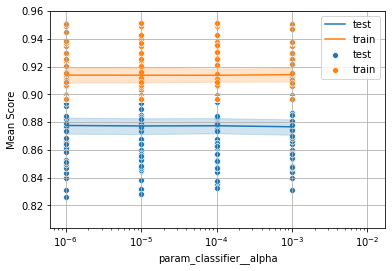

In [213]:
fig, ax = plt.subplots()
results_NN = pd.DataFrame(grid_search_NN.cv_results_)
coi = "param_classifier__alpha"
plt.grid(True)
sns.scatterplot(data=results_NN, x=coi, y = "mean_test_score", label="test", ax = ax)
sns.lineplot(data=results_NN, x=coi, y = "mean_test_score", label="test", ax = ax)
sns.scatterplot(data=results_NN, x=coi, y = "mean_train_score", label = "train",  ax = ax)
sns.lineplot(data=results_NN, x=coi, y = "mean_train_score", label = "train",  ax = ax)
ax.set_ylabel("Mean Score")
ax.set_xscale("log")
#              yerr = plot_results["std_test_score"])

C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\util

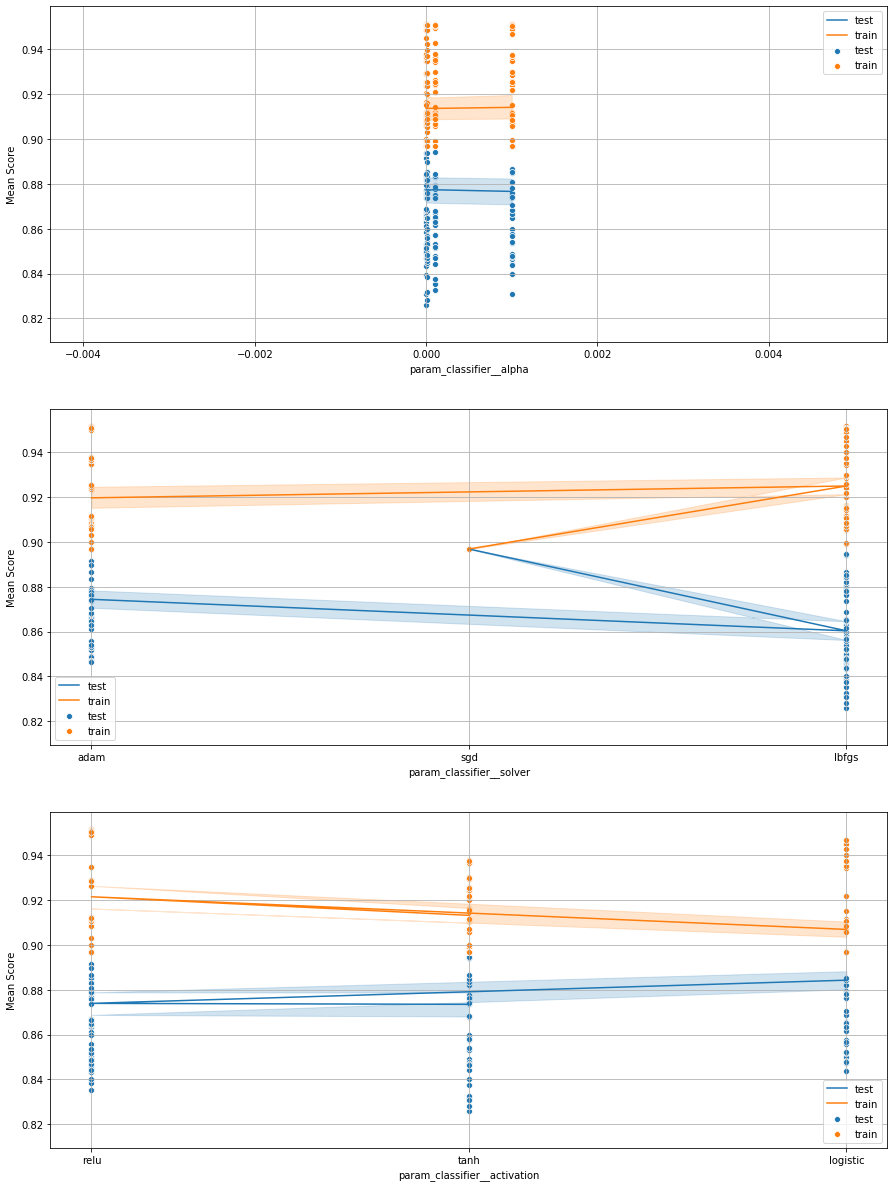

In [192]:
cois = ["param_classifier__alpha", "param_classifier__solver", 
        "param_classifier__activation"]
fig, ax = plt.subplots(nrows=len(cois), figsize=(15,7*len(cois)))
results_NN = pd.DataFrame(grid_search_NN.cv_results_)
for idx, coi in enumerate(cois):
    ax[idx].xaxis.grid(True)
    ax[idx].yaxis.grid(True)
    sns.scatterplot(data=results_NN, x=coi, y = "mean_test_score", label="test", ax = ax[idx])
    sns.lineplot(data=results_NN, x=coi, y = "mean_test_score", label="test", ax = ax[idx])
    sns.scatterplot(data=results_NN, x=coi, y = "mean_train_score", label = "train",  ax = ax[idx])
    sns.lineplot(data=results_NN, x=coi, y = "mean_train_score", label = "train",  ax = ax[idx])
    ax[idx].set_ylabel("Mean Score")
#              yerr = plot_results["std_test_score"])

C:\Users\theop\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Mean Score')

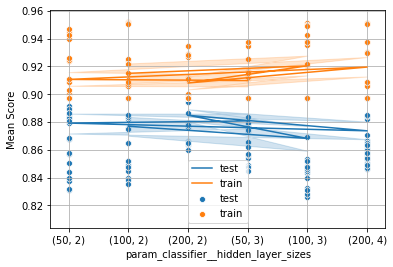

In [198]:
fig, ax = plt.subplots()
res_oi = results_NN[["param_classifier__hidden_layer_sizes", "mean_test_score","mean_train_score"]]
res_oi["param_classifier__hidden_layer_sizes"] = res_oi["param_classifier__hidden_layer_sizes"].apply(str)
coi="param_classifier__hidden_layer_sizes"
plt.grid(True)
sns.scatterplot(data=res_oi, x=coi, y = "mean_test_score", label="test", ax = ax)
sns.lineplot(data=res_oi, x=coi, y = "mean_test_score", label="test", ax = ax)
sns.scatterplot(data=res_oi, x=coi, y = "mean_train_score", label = "train",  ax = ax)
sns.lineplot(data=res_oi, x=coi, y = "mean_train_score", label = "train",  ax = ax)
ax.set_ylabel("Mean Score")
#              yerr = plot_results["std_test_score"])

**should run gradient boosting**


**to do**: 
should have accuracy as a CI so do you bootstrap the process or do you simply train and test the model multiple times on different train - test splits?

In [209]:
pipeline_NN1 = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("classifier", MLPClassifier(random_state=0, solver = "adam", activation = "relu")),
])




parameters_NN1= {
    "classifier__alpha":(1e-6,1e-5),
    "classifier__hidden_layer_sizes":((25,1), (50,1), (100,1), (25,2),(50,2),(100,2),(25,3),(50,3),(100,3)),
    
}

# could look at adaptive momentum, nesterov momentum etc but only applicable to SGD solver so run a 2nd time?
   
# clf.fit(X_train, y_train)
# print("model score: %.3f" % clf.score(X_test, y_test))

In [210]:
grid_search_NN1 = GridSearchCV(pipeline_NN1, parameters_NN1, n_jobs=-1, verbose = 1)

print("gridsearch; pipeline: ", [name for name,_ in pipeline_NN1.steps])
pprint(parameters_NN1)
t0=time()
grid_search_NN1.fit(X_train, y_train)
print("time: {:.3f}".format(time()-t0))
print("time: {:.3f}".format(grid_search_NN1.best_score_))
best_parameters_NN1 = grid_search_NN1.best_estimator_.get_params()
for param_name in sorted(parameters_NN1.keys()):
    print(param_name, best_parameters_NN1[param_name])   
grid_search_NN1.best_score_
# pd.DataFrame(grid_search.cv_results_)

gridsearch; pipeline:  ['preprocessor', 'classifier']
{'classifier__alpha': (1e-06, 1e-05),
 'classifier__hidden_layer_sizes': ((25, 1),
                                    (50, 1),
                                    (100, 1),
                                    (25, 2),
                                    (50, 2),
                                    (100, 2),
                                    (25, 3),
                                    (50, 3),
                                    (100, 3))}
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\Users\theop\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   57.8s finished
C:\Users\theop\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


time: 67.599
time: 0.892
classifier__alpha 1e-06
classifier__hidden_layer_sizes (50, 2)


C:\Users\theop\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.891566265060241